In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import Normalize
%matplotlib widget

from numba import njit, vectorize, float64, guvectorize

import setFigureConfig as sfc
np.random.seed(42)
from colorschemes import tol_cmap

In [2]:
# Some useful definitions
c_light=3.e10              # speed of light--always useful       
m_electron=9.10938356e-28  # electron mass
sigma_t=6.65e-25           # Thomson cross section
mec2 = m_electron*c_light**2
eV2erg = 1.60218e-12
erg2eV = 1/eV2erg

# Generate a random direction vector

In [3]:

def random_direction(number=None, fourD=False, mu_min=-1, mu_max=1):
    """Generate a vector of random orientation uniformly on a sphere
    number: number of vectors to generate
    fourD: fill the first component with a 1
    mu_min: minimum value of cos(theta) to include
    mu_max: maximum value of cos(theta) to include
    """
    if number is None:
        number=1

    phi=2.*np.pi*np.random.rand(number)
    cos_phi=np.cos(phi)
    sin_phi=np.sin(phi)
    cos_theta=np.random.uniform(mu_min, mu_max, number)
    sin_theta=np.sqrt(1 - cos_theta**2)
    if fourD:
        return((np.array([np.ones(number), sin_theta*cos_phi,sin_theta*sin_phi,cos_theta])).transpose())
    else:
        return((np.array([sin_theta*cos_phi,sin_theta*sin_phi,cos_theta])).transpose())


# Lorentz trafo in arbitray direction

In [4]:
@guvectorize(
    [(float64[:], float64[:], float64, float64[:])],
    '(n),(m),()->(n)',
    nopython=True
)
def lorentz_transform_fast(p, beta_vec, gamma, out):
    """performs a Lorentz trafo with beta_vec (and correspoding Lorentz factor gamma) of 4 vector p into out
    p: incoming 4-vector
    beta_vec: 3-vector of Lorentz boost
    gamma: = (1-beta^2)^(-0.5) with beta = magnitude of beta_vec, redundant, only to avoid extra computation
    out: 4-vector in which the result will be written
    """
    p0, p1, p2, p3 = p
    beta1, beta2, beta3 = beta_vec
    g2_1pg = gamma**2/(1+gamma)
    out[0] = gamma*p0 - gamma*beta1*p1 - gamma*beta2*p2 - gamma*beta3*p3
    out[1] = -gamma*beta1*p0 + (1+g2_1pg*beta1**2)*p1 + g2_1pg*beta1*beta2*p2 + g2_1pg*beta1*beta3*p3
    out[2] = -gamma*beta2*p0 + g2_1pg*beta1*beta2*p1 + (1+g2_1pg*beta2**2)*p2 + g2_1pg*beta2*beta3*p3
    out[3] = -gamma*beta3*p0 + g2_1pg*beta1*beta3*p1 + g2_1pg*beta2*beta3*p2 + (1+g2_1pg*beta3**2)*p3
    # return pp0, pp1, pp2, pp3

# Perform scattering

In [5]:
@guvectorize(
    [(float64[:], float64, float64, float64[:])],
    '(n),(),()->(n)',
    nopython=True
    # target='parallel'  # or 'cuda' if you're going GPU
)
def compton_scatter_fast(p, phi, cost, out):
    """performs a Compton scattering with angle phi and cos(theta) of 4 vector p into out
    p: incoming 4-vector
    phi: azimuthal angle around symmetry axis
    cost: = cos(theta) , with theta = scattering angle
    out: 4-vector in which the result will be written
    """
    n_1 = p[1:] / p[0]

    # Choose reference axis to avoid parallel vectors
    if np.abs(n_1[1]) + np.abs(n_1[2]) != 0:
        ref = np.array([1.0, 0.0, 0.0])
    else:
        ref = np.array([0.0, 1.0, 0.0])

    n_2 = np.cross(n_1, ref)
    n_2 /= np.sqrt(np.sum(n_2**2))
    n_3 = np.cross(n_1, n_2)

    sint = np.sqrt(1.0 - cost**2)
    n_new = (n_2 * np.cos(phi) + n_3 * np.sin(phi)) * sint + n_1 * cost
    n_new /= np.sqrt(np.sum(n_new**2))

    pin = p[0]
    p_new = pin / (1.0 + (pin / m_electron / c_light) * (1.0 - cost))

    out[0] = p_new
    out[1] = p_new * n_new[0]
    out[2] = p_new * n_new[1]
    out[3] = p_new * n_new[2]


# Help function to caluclate angle between two vectors

In [6]:
def angle_between(v1, v2, v3, w1, w2, w3):
    """returns cos(theta) between vector v = (v1,v2,v3) and w=(w1,w2,w3)"""
    n1 = np.sqrt(v1**2 + v2**2 + v3**2)
    n2 = np.sqrt(w1**2 + w2**2 + w3**2)
    return (v1*w1 + v2*w2 + v3*w3) /n1 /n2

# Analytical result from https://arxiv.org/abs/1905.00868

In [7]:
def omega_min(omega_0, gamma_0):
    """Compute the minimum scattered photon energy."""
    p_0 = np.sqrt(gamma_0**2- 1)
    return ((gamma_0 - p_0) * omega_0) / (gamma_0 + p_0 + 2 * omega_0)

def omega_max(omega_0, gamma_0):
    """Compute the maximum scattered photon energy."""
    p_0 = np.sqrt(gamma_0**2- 1)
    thigh = gamma_0 + omega_0 - 1
    tlow = omega_c(omega_0, gamma_0)
    return (
        np.greater(omega_0, (1 + p_0 - gamma_0) / 2) * thigh + 
        np.less_equal(omega_0, (1 + p_0 - gamma_0) / 2) * tlow)

def omega_c(omega_0, gamma_0):
    """Compute the critical frequency."""
    p_0 = np.sqrt(gamma_0**2- 1)
    return ((gamma_0 + p_0) * omega_0) / (gamma_0 - p_0 + 2 * omega_0)

    

threshold = 1e-4
@vectorize([float64(float64)])
def Sfun_vec(x):
    if x < threshold:
        return 1- x/6 + 3*x**2/40 - 5*x**3/112
    else:
        return np.arcsinh(np.sqrt(x)) / np.sqrt(x)
@vectorize([float64(float64)])
def Ffun_vec(x):
    if x < threshold:
        return - 2*x/3 + x**2/5 - 3*x**3/28
    else:
        return Sfun_vec(x) - np.sqrt(1+x)

@njit
def G_fun_vec(w0s, ws, kappa, w0, w, g0):

    p0 = np.sqrt(g0**2- 1)
    lambdap = p0**2 + 2*g0*w0 + w0**2
    lambdam = p0**2 - 2*g0*w + w**2
    
    term1 = 2 + (ws - w0s)**2*(1+w*w0)/w**2/w0**2
    term2 = 2*(Sfun_vec(kappa**2*lambdap/ws**2)/ws - Sfun_vec(kappa**2*lambdam/w0s**2)/w0s)
    term3 = (1+w*w0)*(Ffun_vec(kappa**2*lambdap/ws**2)/ws/lambdap - Ffun_vec(kappa**2*lambdam/w0s**2)/w0s/lambdam)
    return kappa*( term1 + term2 + term3)

@njit
def IC_kernel(E_in_lab, bG_el, E_out_lab):
    w0 = E_in_lab/mec2
    w = E_out_lab/mec2
    g0 = np.sqrt(1 + bG_el**2)
    # b0 = np.sqrt(1 - 1/g0**2)
    p0 = bG_el
    p = np.sqrt(p0**2 + 2*g0*(w0-w) + (w0 - w)**2)
    g = np.sqrt(1 + p**2)

    wc = ((g0 + p0) * w0) / (g0 - p0 + 2 * w0)
    w0b = np.sqrt((w * w0 * (g0 + p0)) / (g + p))
    wb = np.sqrt((w * w0 * (g + p)) / (g0 + p0))
    wmin = ((g0 - p0) * w0) / (g0 + p0 + 2 * w0)
    if w0 > (1 + p0 - g0) / 2:
        wmax = g0 + w0 - 1
    else:
        wmax = wc

    prefac = 3/(8*g0*p0*w0**2)
    if wc <= w0:
        kappa1 = (p0 - p + w0 + w) / 2
        if (w >= wmin) and (w < wc):
            return prefac*G_fun_vec(w0b, wb, kappa1, w0, w, g0)
        elif (w >= wc) and (w < w0):
            return prefac*G_fun_vec(w, w0, p0, w0, w, g0)
        elif (w >= w0) and (w < wmax):
            return prefac*G_fun_vec(w0, w, p, w0, w, g0)
        else:
            return 0.0
    else:
        kappa1 = (p0 - p + w0 + w) / 2
        kappa2 = (p - p0 + w + w0) / 2
        if (w >= wmin) and (w < w0):
            return prefac*G_fun_vec(w0b, wb, kappa1, w0, w, g0)
        elif (w >= w0) and (w < wc):
            return prefac*G_fun_vec(wb, w0b, kappa2, w0, w, g0)
        elif (w >= w0) and (w < wmax):
            return prefac*G_fun_vec(w0, w, p, w0, w, g0)
        else:
            return 0.0
    
IC_kernel_vec = np.vectorize(IC_kernel)

# Scattering probabilities (cross section)

In [8]:
@vectorize([float64(float64,float64)])
def dsigma_KNdmu(eps_in, mu):
    if eps_in < 1e-3:
        return 3/8 * (1 + mu**2)
    else:
        eps_out = eps_in/(1+eps_in*(1-mu))
        return 3/8 *(eps_out/eps_in)**2 * (eps_out/eps_in + eps_in/eps_out - 1 +mu**2)

@vectorize([float64(float64)])
def sigma_KN(u):
    if u < 1e-3:
        return 1.
    elif u > 1e3:
        return 3/8 * (np.log(2*u)+0.5)/u
    else:
        return 3/4 /u**2 * ( 
            2 +
            u**2*(1+u)/(1+2*u)**2 +
            (u**2-2*u-2)/2/u * np.log(1+2*u)
        )
@vectorize([float64(float64,float64)])
def P_mu_KN(mu, eps_in):
    return dsigma_KNdmu(eps_in, mu) #/ sigma_KN(eps_in)

P_mu_KN_vec = np.vectorize(P_mu_KN)

# from https://physics.stackexchange.com/questions/659180/probability-distribution-function-of-the-photons-scattering-angle
def I(eps_in, mu):
    R = eps_in
    term1 = -mu / R**2
    term2 = np.log(1 + R * (1 - mu)) * (1/R - 2 / R**2 - 2 / R**3)
    term3 = -1 / (2 * R * (1 + R * (1 - mu))**2)
    term4 = 1/(1 + R * (1 - mu)) * (-2 / R**2 - 1 / R**3)
    return term1 + term2 + term3 + term4

def P_mu_KN_integrated(eps_in, mu):
    return (I(eps_in, mu)-I(eps_in, 1)) / (I(eps_in, -1)-I(eps_in, 1))

def mu_KN_integrated_inv(P, eps_in, mu_array_small, mu_array_large):
    if eps_in < 1e-1:
        a=-4 + 8*P
        b=a**2 + 4
        term = ((np.sqrt(b) - a )/2)**(1/3)
        return term - 1/term
    else:
        if eps_in > 1e5:
            mus = mu_array_large
        else:
            mus = mu_array_small
        return mus[np.argmin((P - P_mu_KN_integrated(eps_in, mus))**2)]
    
# Calculate the scattering angle for a probability between 0 and 1
def cos_theta_thomson(p):
    """Invert P(<\theta) = [int_{cos \theta}^{1} (1+x^2)]/[int_{-1}^{1} (1+x^2)] to draw cos(theta)
        
        Args:
            p (real): probability between 0 and 1
            
        Returns:
            real: scattering angle drawn from Thomson distribution
    """
    a=-4 + 8*p
    b=a**2 + 4
    term = ((np.sqrt(b) - a )/2)**(1/3)
    return term - 1/term



# function to plot a photon (wiggly line)

In [9]:
def plot_photon(ax, start, direction, wavelength=1, amplitude=0.1, num_waves=4, cone_size=0.3, cone_angle=np.pi/10, cone_resolution=30, color="tab:blue", colortip="darkblue", ls="-"):
    """Plots a wiggly photon line in 3D with a cone at the end, aligned with the gradient.
    ax: the plot ax
    start: the start position (3D vector)
    direction: direction of the photon (3D vector)
    wavelength: wavelength of the wiggly line
    amplitude: amplitude of the wiggly line
    num_waves: number of wavelengths to plot
    cone_size: size of cone at tip of photon wiggly line
    cone_angle: opening angle of cone
    cone_resolution: resolution of cone
    color: color of wiggly line
    colortip: color of cone
    ls: linestyle of wiggly line (matplotlib arguments)
    """
    direction = direction / np.linalg.norm(direction)  # Normalize propagation direction

    # Generate parameterized t for the wavy line
    t = np.linspace(0, num_waves * wavelength, 100)
    
    # Compute a perpendicular vector for oscillation
    perp1 = np.array([-direction[1], direction[0], 0])
    if np.linalg.norm(perp1) == 0:
        perp1 = np.array([1., 0., 0.])  # Ensure it's not zero
    perp1 /= np.linalg.norm(perp1)  

    perp2 = np.cross(direction, perp1)  # Second perpendicular vector
    perp2 /= np.linalg.norm(perp2)

    # Create a sinusoidal perturbation perpendicular to propagation
    oscillation = amplitude * np.sin(2 * np.pi * t / wavelength)
    x = start[0] + t * direction[0] + oscillation * perp1[0]
    y = start[1] + t * direction[1] + oscillation * perp1[1]
    z = start[2] + t * direction[2] + oscillation * perp1[2]

    # Plot the wiggly line
    ax.plot(x, y, z, color=color, ls=ls)

    # Compute gradient at endpoint for cone orientation
    dt = (t[-1] - t[-2])  # Small step for numerical derivative
    grad_x = (x[-1] - x[-2]) / dt
    grad_y = (y[-1] - y[-2]) / dt
    grad_z = (z[-1] - z[-2]) / dt
    gradient = np.array([grad_x, grad_y, grad_z])
    gradient /= np.linalg.norm(gradient)  # Normalize the gradient

    # Compute cone base
    cone_tip = np.array([x[-1], y[-1], z[-1]])

    # Create a perpendicular base for the cone
    base_perp1 = np.cross(gradient, [1, 0, 0])  
    if np.linalg.norm(base_perp1) == 0:
        base_perp1 = np.array([0, 1, 0])  # Ensure it's not zero
    base_perp1 /= np.linalg.norm(base_perp1)

    base_perp2 = np.cross(gradient, base_perp1)
    base_perp2 /= np.linalg.norm(base_perp2)

    # Compute cone base circle
    base_radius = cone_size * np.tan(cone_angle)
    base_center = cone_tip - cone_size * gradient  # Base center a bit behind the tip
    theta = np.linspace(0, 2 * np.pi, cone_resolution)
    circle_x = base_center[0] + base_radius * np.cos(theta) * base_perp1[0] + base_radius * np.sin(theta) * base_perp2[0]
    circle_y = base_center[1] + base_radius * np.cos(theta) * base_perp1[1] + base_radius * np.sin(theta) * base_perp2[1]
    circle_z = base_center[2] + base_radius * np.cos(theta) * base_perp1[2] + base_radius * np.sin(theta) * base_perp2[2]

    # Draw the cone
    cone_faces = [[cone_tip, [circle_x[i], circle_y[i], circle_z[i]], [circle_x[i+1], circle_y[i+1], circle_z[i+1]]]
                  for i in range(len(theta) - 1)]
    ax.add_collection3d(Poly3DCollection(cone_faces, color=colortip, alpha=0.6))


# Function to change a plot

In [10]:
def updateplot(figs, axes, betaGamma_el, E_ph_in_eV, N_MC, N_phot_plot,updateAngles, blackDots, alphaDots, plotElOut, plotElIn, elcostheta, elphi, KNswitch, mu_phot_min, mu_phot_max, plotcurves):
    ax, axmu, ax1, ax2, ax3, ax4 =axes
    fig, fig2 = figs
    N_MC = int(N_MC)
    for line in ax.get_lines():
        line.remove()

    # sample photons
    hnu= E_ph_in_eV*eV2erg # erg
    p_photon = hnu/c_light * random_direction(N_MC, True, mu_phot_min, mu_phot_max)

    sineltheta = np.sin(np.arccos(elcostheta))
    n_el_in = np.array([[sineltheta*np.cos(elphi),sineltheta*np.sin(elphi),elcostheta] for i in range(N_MC)])
    bGel = betaGamma_el
    Gel = np.sqrt(1 + bGel**2)
    bel = np.sqrt(1 - 1/Gel**2)
    p_photon_prime_fast= np.empty_like(p_photon)
    lorentz_transform_fast(p_photon, bel*n_el_in, Gel, p_photon_prime_fast)
    
    
    p_out_prime_fast= np.empty_like(p_photon)
    phi_scatter = np.random.uniform(0, 2*np.pi, N_MC)
    # cos_theta_scatter = np.random.uniform(-1, 1, N_MC)
    # cos_theta_scatter = cos_theta_thomson(np.random.uniform(0, 1, N_MC))
    if KNswitch:
        uniform_angles = np.random.uniform(0, 1, N_MC)
        mu_array_small = np.linspace(-1,1, 1000)
        mu_array_large = np.linspace(-1,1, 10000)
        cos_theta_scatter = np.array([mu_KN_integrated_inv(uniform_angles[i], p_photon_prime_fast[i][0]*c_light/mec2, mu_array_small, mu_array_large) for i in range(N_MC)])
    else:
        cos_theta_scatter = cos_theta_thomson(np.random.uniform(0, 1, N_MC))
    compton_scatter_fast(p_photon_prime_fast, phi_scatter, cos_theta_scatter, p_out_prime_fast)

    p_out_fast = np.empty_like(p_photon)
    lorentz_transform_fast(p_out_prime_fast, -bel*n_el_in, Gel, p_out_fast)

    cos_alpha_ins_fast = angle_between(p_photon[:,1], p_photon[:,2], p_photon[:,3], n_el_in[:,0], n_el_in[:,1], n_el_in[:,2])
    cos_thetas_prime_fast = angle_between(p_photon_prime_fast[:,1], p_photon_prime_fast[:,2], p_photon_prime_fast[:,3], p_out_prime_fast[:,1], p_out_prime_fast[:,2], p_out_prime_fast[:,3])
    cos_alpha_scattering = angle_between(p_photon[:,1], p_photon[:,2], p_photon[:,3], p_out_fast[:,1], p_out_fast[:,2], p_out_fast[:,3])
    # cos_alpha_ins = np.einsum('ij,ij->i', p_photon[:,1:], -n_el_in) / p_photon[:,0]
    # cos_thetas_prime = np.einsum('ij,ij->i', p_photon_prime_fast[:,1:], p_out_prime_fast[:, 1:]) / p_photon_prime_fast[:,0] / p_out_prime_fast[:,0]

    weights_vecs = (1-bel*cos_alpha_ins_fast)/2 #* P_mu_KN_vec(cos_theta_scatter, p_photon_prime_fast[:,0]/m_electron/c_light)
    weights_alpha_vecs = (1-bel*cos_alpha_ins_fast)/2

    if plotcurves:
        hist,ed=np.histogram(np.log10(p_out_fast[:,0]*c_light/mec2),bins=100,density=True, weights=weights_vecs) # dN/dlog10(E/mec2)
        tmid=0.5*(ed[1:]+ed[:-1]) #+ np.log10(c_light)
        ax.plot(tmid, hist,c="tab:brown",  label=r"$(1+\beta \cos \alpha)(1+\cos^2 \theta')$")
    


        Eouts = np.logspace(np.log10(omega_min(hnu/mec2, Gel)), np.log10(omega_max(hnu/mec2, Gel)), 1000) * mec2
        dlogE = np.log(Eouts[1]/Eouts[0])
        IC_kernel_plot = IC_kernel_vec(hnu, bGel, Eouts)* Eouts/mec2
        integral = np.sum(IC_kernel_plot) * dlogE
        # print(integral)
        ax.plot(np.log10(Eouts/mec2), IC_kernel_plot*np.log(10) / integral, color="tab:red", label="Sarkar++19", ls="--")
    
    
        # Eouts = np.logspace(np.log10(hnu)-1, np.log10(Gel)+0.5, 300)
        # Eelin = Gel * mec2
        b = 4 * Gel * hnu/m_electron/c_light**2
        # q = Eouts/Eelin /b/ (1 - Eouts/Eelin)
        # # log_a (b) = ln(b)/ln(a)
        # ax.plot(np.log10(Eouts/mec2), 3/4 *(2*q*np.log(q) + (1+2*q)*(1-q)+0.5*(b*q)**2/(1+b*q)*(1-q)) /Gel**2 /hnu *Eouts *np.log(10), c="tab:orange", ls="-.", label="BG70 iso. analytical") 
        # ax.plot(np.log10(Eouts/mec2), 3/4 *(-2*q*np.log(q) ) /Gel**2 /hnu *Eouts *np.log(10), c="tab:orange", ls=":") 
        # ax.plot(np.log10(Eouts/mec2), 3/4 *((1+2*q)*(1-q) ) /Gel**2 /hnu *Eouts *np.log(10), c="tab:orange", ls="--") 
        # e1hat = Eouts/ 4/ Gel**2 / hnu
        # ax.plot(np.log10(Eouts/mec2), (2*e1hat*np.log(e1hat) + e1hat + 1 - 2* e1hat**2) *Eouts *np.log(10) /( 4*Gel**2 * hnu) * 3, c="tab:red", ls="--", label="iso. ana. Thomson")
        ax.set_title(f"b={b:.1e}", loc="right")
        ax.set_xlim(np.log10(E_ph_in_eV*eV2erg/mec2)-3, max(np.log10(bGel)+1, np.log10(hnu/mec2)+1))
        ax.legend()


        axmu.clear()

        axmu.set_xlim(-1.1, 1.1)
        # axmu.set_xlabel(r"$\cos \alpha_{out}$")
        axmu.set_xlabel(r"cos angle")
        # ax2.set_ylim(1e-6, 10)
        axmu.set_yscale("log")
        axmu.grid(alpha=0.3)
        
        # axmu.hist(cos_alpha_ins_fast, bins=100, density=True, histtype=u'step', weights=weights_vecs, label=r"$\alpha_{in}$")
        axmu.hist(cos_thetas_prime_fast, bins=100, density=True, histtype=u'step', weights=weights_vecs, label=r"$\cos \theta'$")
        # axmu.hist(cos_theta_scatter, bins=100, density=True, histtype=u'step', weights=weights_vecs, label=r"$\cos \theta_{scat}'$")
        axmu.hist(cos_alpha_scattering, bins=100, density=True, histtype=u'step', weights=weights_vecs, label=r"$\cos \alpha_{scat}$")
        # ax2.hist(np.cos(alpha1s), bins=100, density=True, histtype=u'step', weights=KN_weights, label=r"$(1+\beta \cos \alpha)(E_o/E_i)(E_o/E_i + E_i/E_o - 1 +\cos^2 \theta') $")

        mus_plot = np.linspace(-1, 1, 300)
        axmu.plot(mus_plot, (1+mus_plot**2)* 3/8, c="k", ls="--")
        axmu.plot(mus_plot, dsigma_KNdmu(hnu/mec2, mus_plot)/sigma_KN(hnu/mec2), c="grey", ls="--")
        # axmu.plot(mus_plot, dsigma_KNdmu(hnu/mec2, mus_plot), c="grey", ls="--")
        axmu.legend()
        # ax2.set_title(r"$\Gamma_{el} E_{in}/mc^2=" + f"{G*hnu/mec2:.1e}" + r"$")

        fig.tight_layout()

    # centers = [np.zeros(3) for i in range(N_MC)]
    col_before = "tab:blue"
    coltip_before = "darkblue"
    col_after = "tab:green"
    coltip_after = "darkgreen"
    if updateAngles:
        cmap = tol_cmap("rainbow_PuRd")
        colmin = min(np.log10(p_out_fast[:,0]*c_light))
        colmax = max(np.log10(p_out_fast[:,0]*c_light))
        norm = Normalize(vmin=colmin, vmax=max(colmin+1, colmax))
        for line in ax1.get_lines():
            line.remove()
        for line in ax1.collections:
            line.remove()
        for line in ax2.get_lines():
            line.remove()
        for line in ax2.collections:
            line.remove()
        for line in ax3.get_lines():
            line.remove()
        for line in ax3.collections:
            line.remove()
        for line in ax4.get_lines():
            line.remove()
        for line in ax4.collections:
            line.remove()
            
        fac = 4
        for i in range(N_phot_plot):
            index = np.random.randint(0, N_MC-1)
            p_photon_plot = p_photon[index][1:] / p_photon[index][0]
            plot_photon(ax1, -fac*p_photon_plot, p_photon_plot, color=cmap(norm(np.log10(hnu))), colortip=cmap(norm(np.log10(hnu))))
            
            p_photon_prime_plot = p_photon_prime_fast[index][1:] / p_photon_prime_fast[index][0]
            plot_photon(ax2, -fac*p_photon_prime_plot, p_photon_prime_plot, 
                        color=cmap(norm(np.log10(p_photon_prime_fast[index][0]*c_light))), 
                        colortip=cmap(norm(np.log10(p_photon_prime_fast[index][0]*c_light))))
            
            p_out_prime_plot = p_out_prime_fast[index][1:] / p_out_prime_fast[index][0]
            plot_photon(ax4, np.zeros(3), p_out_prime_plot, 
                        color=cmap(norm(np.log10(p_out_prime_fast[index][0]*c_light))), colortip=cmap(norm(np.log10(p_out_prime_fast[index][0]*c_light))))
            p_out_plot = p_out_fast[index][1:] / p_out_fast[index][0]
            plot_photon(ax3, np.zeros(3), p_out_plot, 
                        color=cmap(norm(np.log10(p_out_fast[index][0]*c_light))), colortip=cmap(norm(np.log10(p_out_fast[index][0]*c_light))))
            if plotElOut:
                p_el_in_plot = m_electron*c_light * np.array([Gel, *(betaGamma_el*n_el_in[index])] )
                p_el_out_plot = p_photon[index] + p_el_in_plot - p_out_fast[index]
                # n_el_out_plot = p_el_out_plot[1:] / p_el_out_plot[0]
                p_el_out_tot = np.sqrt(p_el_out_plot[1]**2 + p_el_out_plot[2]**2 + p_el_out_plot[3]**2)
                num_waves = 4
                plot_photon(ax3, [0,0,0], p_el_out_plot[1:], amplitude=0., color="k", colortip="k", cone_size=0.3, ls="-", num_waves=num_waves)

        if plotElIn:
            plot_photon(ax1, -fac*n_el_in[0], n_el_in[0], amplitude=0., color="k", colortip="k", cone_size=0.3)
            plot_photon(ax3, -fac*n_el_in[0], n_el_in[0], amplitude=0., color="grey", colortip="grey", cone_size=0.3, ls="--")
        else:
            ax1.plot([0], [0], [0], marker="o", color="k")
            ax3.plot([0], [0], [0], marker="o", color="k")

        ax2.plot([0], [0], [0], marker="o", color="k")
        ax4.plot([0], [0], [0], marker="o", color="k")

        c_sphere = "k"
        if alphaDots> 1e-5:
            p_photon_scatter1 = fac* p_photon[:,1] / p_photon[:,0]
            p_photon_scatter2 = fac* p_photon[:,2] / p_photon[:,0]
            p_photon_scatter3 = fac* p_photon[:,3] / p_photon[:,0]
            if blackDots:
                colordots = c_sphere
            else:
                colordots = cmap(norm(np.log10(p_photon[:,0]*c_light)))
            ax1.scatter3D(p_photon_scatter1, p_photon_scatter2, p_photon_scatter3, color=colordots, alpha=alphaDots, marker=".")

            p_photon_prime_scatter1 = fac* p_photon_prime_fast[:,1] / p_photon_prime_fast[:,0]
            p_photon_prime_scatter2 = fac* p_photon_prime_fast[:,2] / p_photon_prime_fast[:,0]
            p_photon_prime_scatter3 = fac* p_photon_prime_fast[:,3] / p_photon_prime_fast[:,0]
            if blackDots:
                colordots = c_sphere
            else:
                colordots = c_primes = cmap(norm(np.log10(p_photon_prime_fast[:,0]*c_light)))
            ax2.scatter3D(p_photon_prime_scatter1, p_photon_prime_scatter2, p_photon_prime_scatter3, color=colordots, alpha=alphaDots, marker=".")
                
            p_out_scatter1 = fac* p_out_fast[:,1] / p_out_fast[:,0]
            p_out_scatter2 = fac* p_out_fast[:,2] / p_out_fast[:,0]
            p_out_scatter3 = fac* p_out_fast[:,3] / p_out_fast[:,0]
            if blackDots:
                colordots = c_sphere
            else:
                colordots = c_primes = cmap(norm(np.log10(p_out_prime_fast[:,0]*c_light)))
            ax3.scatter3D(p_out_scatter1, p_out_scatter2, p_out_scatter3, color=colordots, alpha=alphaDots, marker=".")
            
        
            p_out_prime_scatter1 = fac* p_out_prime_fast[:,1] / p_out_prime_fast[:,0]
            p_out_prime_scatter2 = fac* p_out_prime_fast[:,2] / p_out_prime_fast[:,0]
            p_out_prime_scatter3 = fac* p_out_prime_fast[:,3] / p_out_prime_fast[:,0]
            if blackDots:
                colordots = c_sphere
            else:
                colordots = c_primes = cmap(norm(np.log10(p_out_prime_fast[:,0]*c_light)))
            ax4.scatter3D(p_out_prime_scatter1, p_out_prime_scatter2, p_out_prime_scatter3, color=colordots, alpha=alphaDots, marker=".")
        
        fig2.tight_layout()

# Thomson scattering

In [11]:
fig, (ax, axmu) = plt.subplots(ncols=2, figsize=(10,5))
ax.set_yscale("log")
ax.set_ylim(1e-6, 5)
ax.set_aspect("equal")
ax.set_xlabel(r"photon out energy $\log_{10} E/m_ec^2$")
ax.set_ylabel(r"pdf = $dN/d\log_{10}(E/m_ec^2)$")
fig.tight_layout()

fig2, ((ax1, ax3), (ax2, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(8,8), subplot_kw={'projection': '3d'})
for axi in [ax1, ax2, ax3, ax4]:
    axi.set_xlim(-4, 4)
    axi.set_ylim(-4, 4)
    axi.set_zlim(-4, 4)
    axi.set_aspect("equal")
    axi.view_init(elev=10., azim=45)
ax1.set_title("lab frame before scattering", y=0.94)
ax2.set_title("electron rest frame before scattering", y=0.94)
ax4.set_title("electron rest frame after scattering", y=0.94)
ax3.set_title("lab frame after scattering", y=0.94)

updateplot([fig, fig2], [ax, axmu, ax1, ax2, ax3, ax4], 
           betaGamma_el=1e-7, E_ph_in_eV=1, 
           N_MC=1e5, N_phot_plot=1, updateAngles=True, blackDots=False, alphaDots=2e-3, 
           plotElOut=False, plotElIn=False, 
           elcostheta=1, elphi=1, KNswitch=False, 
           mu_phot_min=-1, mu_phot_max=-0.99999, plotcurves=True)

# sfc.saveFigure(fig, "blogpost/Thomson_spectra", pdf=False)
sfc.saveFigure(fig2, "blogpost/Thomson", pdf=False)

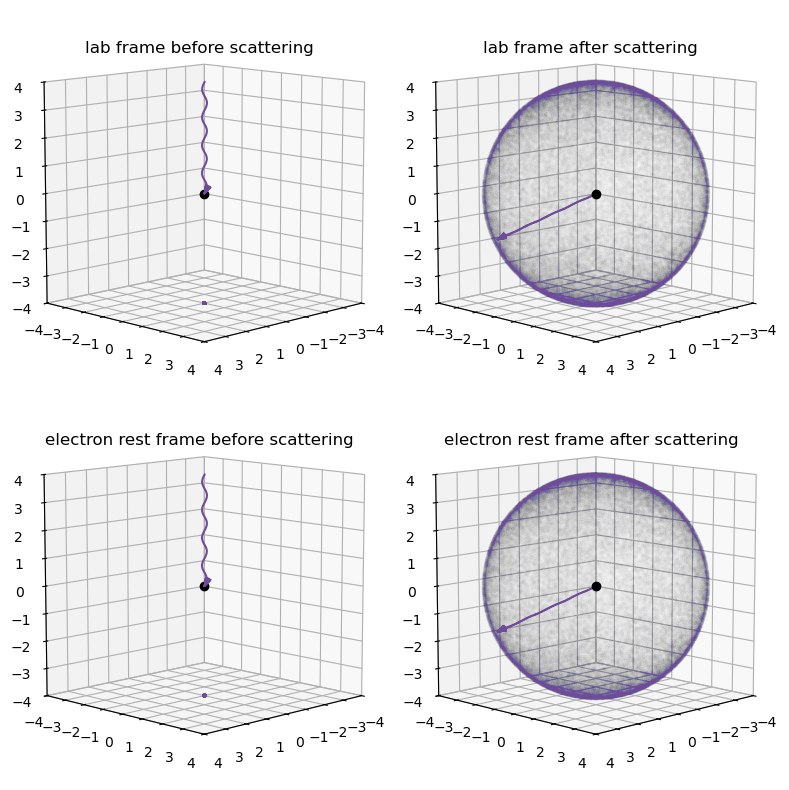

In [12]:
fig2

# Compton scattering

In [13]:
fig, (ax, axmu) = plt.subplots(ncols=2, figsize=(10,5))
ax.set_yscale("log")
ax.set_ylim(1e-6, 5)
ax.set_aspect("equal")
ax.set_xlabel(r"photon out energy $\log_{10} E/m_ec^2$")
ax.set_ylabel(r"pdf = $dN/d\log_{10}(E/m_ec^2)$")
fig.tight_layout()

fig2, ((ax1, ax3), (ax2, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(8,8), subplot_kw={'projection': '3d'})
for axi in [ax1, ax2, ax3, ax4]:
    axi.set_xlim(-4, 4)
    axi.set_ylim(-4, 4)
    axi.set_zlim(-4, 4)
    axi.set_aspect("equal")
    axi.view_init(elev=10., azim=45)
ax1.set_title("lab frame before scattering", y=0.94)
ax2.set_title("electron rest frame before scattering", y=0.94)
ax4.set_title("electron rest frame after scattering", y=0.94)
ax3.set_title("lab frame after scattering", y=0.94)

updateplot([fig, fig2], [ax, axmu, ax1, ax2, ax3, ax4], 
           betaGamma_el=1e-7, E_ph_in_eV=1e7, 
           N_MC=1e5, N_phot_plot=40, updateAngles=True, blackDots=False, alphaDots=2e-3, 
           plotElOut=True, plotElIn=False, 
           elcostheta=1, elphi=1, KNswitch=False, 
           mu_phot_min=-1, mu_phot_max=-0.99999, plotcurves=True)

# sfc.saveFigure(fig, "blogpost/Compton_spectra", pdf=False)
sfc.saveFigure(fig2, "blogpost/Compton", pdf=False)

/Users/marc/micromamba/envs/grb/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in IC_kernel (vectorized)
  outputs = ufunc(*inputs)


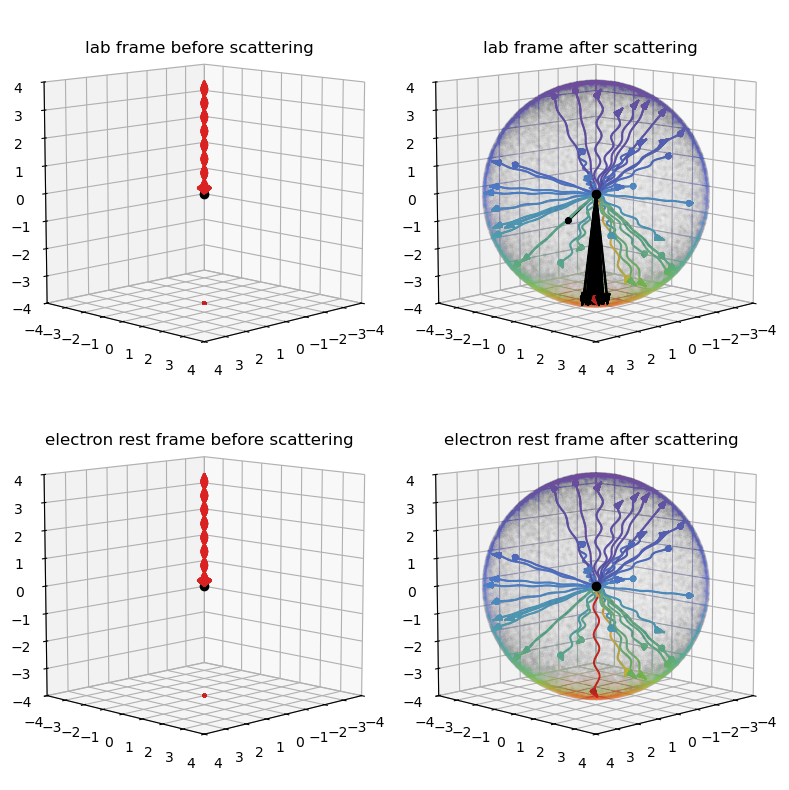

In [14]:
fig2 

# Klein-Nishina scattering

In [15]:
fig, (ax, axmu) = plt.subplots(ncols=2, figsize=(10,5))
ax.set_yscale("log")
ax.set_ylim(1e-6, 5)
ax.set_aspect("equal")
ax.set_xlabel(r"photon out energy $\log_{10} E/m_ec^2$")
ax.set_ylabel(r"pdf = $dN/d\log_{10}(E/m_ec^2)$")
fig.tight_layout()

fig2, ((ax1, ax3), (ax2, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(8,8), subplot_kw={'projection': '3d'}, constrained_layout=True)
for axi in [ax1, ax2, ax3, ax4]:
    axi.set_xlim(-4, 4)
    axi.set_ylim(-4, 4)
    axi.set_zlim(-4, 4)
    axi.set_aspect("equal")
    axi.view_init(elev=10., azim=45)
ax1.set_title("lab frame before scattering", y=0.94)
ax2.set_title("electron rest frame before scattering", y=0.94)
ax4.set_title("electron rest frame after scattering", y=0.94)
ax3.set_title("lab frame after scattering", y=0.94)

updateplot([fig, fig2], [ax, axmu, ax1, ax2, ax3, ax4], 
           betaGamma_el=1e-3, E_ph_in_eV=1e7, 
           N_MC=1e4, N_phot_plot=70, updateAngles=True, blackDots=False, alphaDots=2e-2, 
           plotElOut=True, plotElIn=False, 
           elcostheta=1, elphi=1, KNswitch=True, 
           mu_phot_min=-1, mu_phot_max=-0.9999, plotcurves=True)

# sfc.saveFigure(fig, "blogpost/Compton_KN_spectra", pdf=False)
sfc.saveFigure(fig2, "blogpost/Compton_KN", pdf=False)

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_39817/562636012.py:201: UserWarning: The figure layout has changed to tight
  fig2.tight_layout()


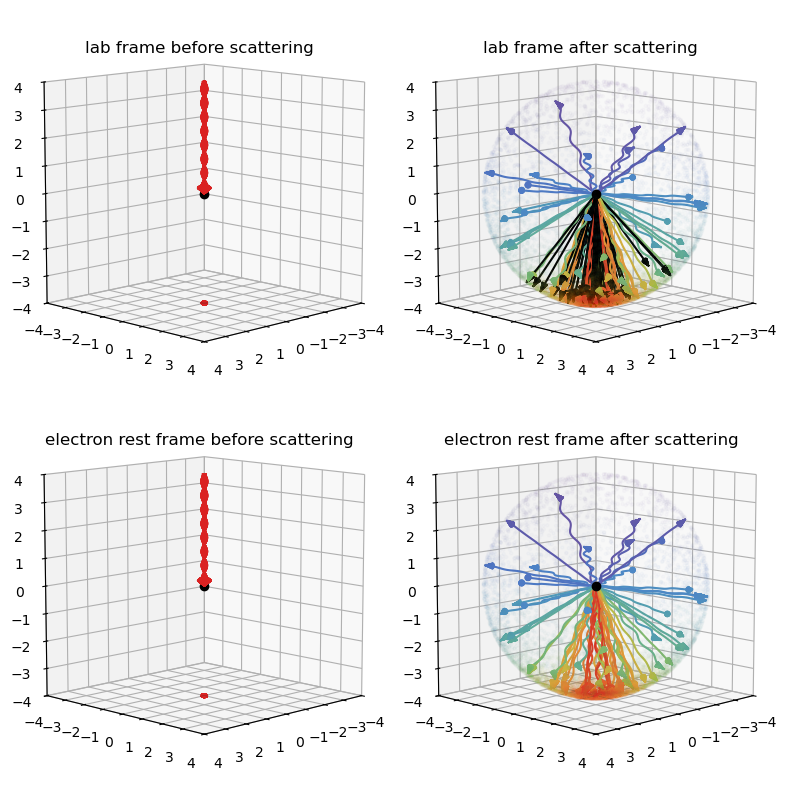

In [16]:
fig2

# Mildly relativistic electron, Thomson regime

In [17]:
fig, (ax, axmu) = plt.subplots(ncols=2, figsize=(10,5))
ax.set_yscale("log")
ax.set_ylim(1e-6, 5)
ax.set_aspect("equal")
ax.set_xlabel(r"photon out energy $\log_{10} E/m_ec^2$")
ax.set_ylabel(r"pdf = $dN/d\log_{10}(E/m_ec^2)$")
fig.tight_layout()

fig2, ((ax1, ax3), (ax2, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(8,8), subplot_kw={'projection': '3d'}, constrained_layout=True)
for axi in [ax1, ax2, ax3, ax4]:
    axi.set_xlim(-4, 4)
    axi.set_ylim(-4, 4)
    axi.set_zlim(-4, 4)
    axi.set_aspect("equal")
    axi.view_init(elev=10., azim=45)
ax1.set_title("lab frame before scattering", y=0.94)
ax2.set_title("electron rest frame before scattering", y=0.94)
ax4.set_title("electron rest frame after scattering", y=0.94)
ax3.set_title("lab frame after scattering", y=0.94)

updateplot([fig, fig2], [ax, axmu, ax1, ax2, ax3, ax4], 
           betaGamma_el=3, E_ph_in_eV=1, 
           N_MC=1e4, N_phot_plot=70, updateAngles=True, blackDots=False, alphaDots=2e-2, 
           plotElOut=True, plotElIn=True, 
           elcostheta=1, elphi=1, KNswitch=False, 
           mu_phot_min=-1, mu_phot_max=1, plotcurves=True)

# sfc.saveFigure(fig, "blogpost/IC_Thomson_iso_spectra", pdf=False)
sfc.saveFigure(fig2, "blogpost/IC_Thomson_iso", pdf=False)

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_39817/562636012.py:201: UserWarning: The figure layout has changed to tight
  fig2.tight_layout()


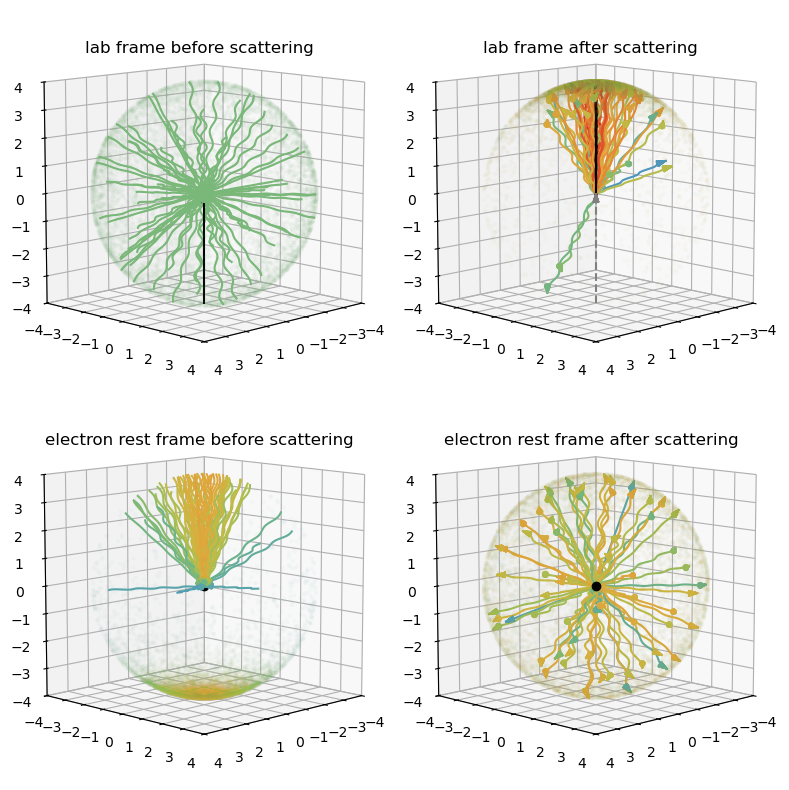

In [18]:
fig2

# Ultra-relativistic Electron, Thomson regime

In [19]:
fig, (ax, axmu) = plt.subplots(ncols=2, figsize=(10,5))
ax.set_yscale("log")
ax.set_ylim(1e-6, 5)
ax.set_aspect("equal")
ax.set_xlabel(r"photon out energy $\log_{10} E/m_ec^2$")
ax.set_ylabel(r"pdf = $dN/d\log_{10}(E/m_ec^2)$")
fig.tight_layout()

fig2, ((ax1, ax3), (ax2, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(8,8), subplot_kw={'projection': '3d'}, constrained_layout=True)
for axi in [ax1, ax2, ax3, ax4]:
    axi.set_xlim(-4, 4)
    axi.set_ylim(-4, 4)
    axi.set_zlim(-4, 4)
    axi.set_aspect("equal")
    axi.view_init(elev=10., azim=45)
ax1.set_title("lab frame before scattering", y=0.94)
ax2.set_title("electron rest frame before scattering", y=0.94)
ax4.set_title("electron rest frame after scattering", y=0.94)
ax3.set_title("lab frame after scattering", y=0.94)

updateplot([fig, fig2], [ax, axmu, ax1, ax2, ax3, ax4], 
           betaGamma_el=300, E_ph_in_eV=1, 
           N_MC=1e4, N_phot_plot=70, updateAngles=True, blackDots=False, alphaDots=2e-2, 
           plotElOut=True, plotElIn=True, 
           elcostheta=1, elphi=1, KNswitch=False, 
           mu_phot_min=-1, mu_phot_max=1, plotcurves=True)

# sfc.saveFigure(fig, "blogpost/IC_Thomson_iso_urel_spectra", pdf=False)
sfc.saveFigure(fig2, "blogpost/IC_Thomson_iso_urel", pdf=False)

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_39817/562636012.py:201: UserWarning: The figure layout has changed to tight
  fig2.tight_layout()


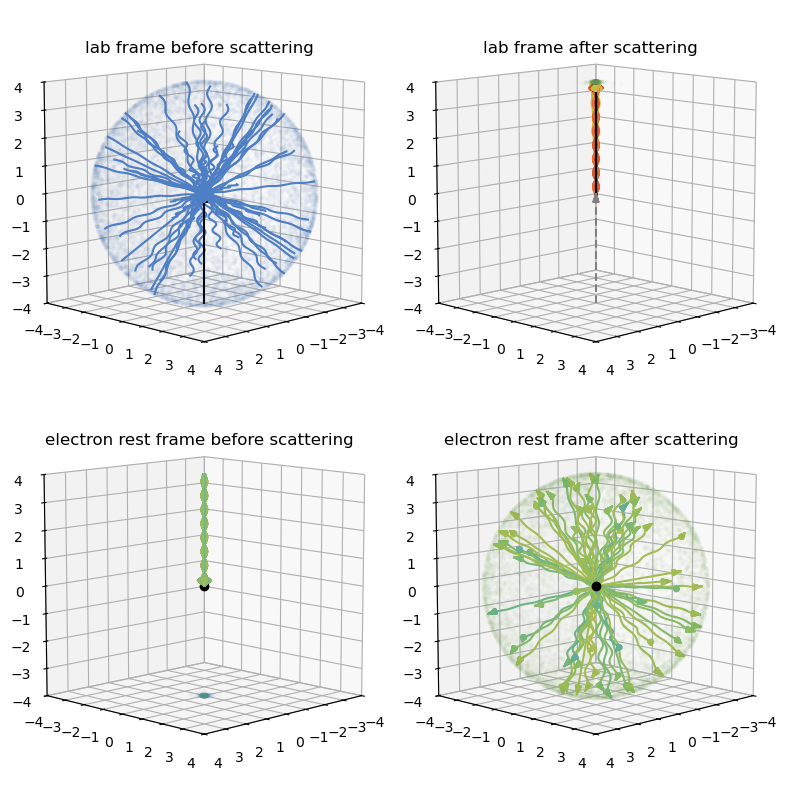

In [20]:
fig2

# Ultra-relativistic Electron, Klein-Nishina regime

In [21]:
fig, (ax, axmu) = plt.subplots(ncols=2, figsize=(10,5))
ax.set_yscale("log")
ax.set_ylim(1e-6, 5)
ax.set_aspect("equal")
ax.set_xlabel(r"photon out energy $\log_{10} E/m_ec^2$")
ax.set_ylabel(r"pdf = $dN/d\log_{10}(E/m_ec^2)$")
fig.tight_layout()

fig2, ((ax1, ax3), (ax2, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(8,8), subplot_kw={'projection': '3d'}, constrained_layout=True)
for axi in [ax1, ax2, ax3, ax4]:
    axi.set_xlim(-4, 4)
    axi.set_ylim(-4, 4)
    axi.set_zlim(-4, 4)
    axi.set_aspect("equal")
    axi.view_init(elev=10., azim=45)
ax1.set_title("lab frame before scattering", y=0.94)
ax2.set_title("electron rest frame before scattering", y=0.94)
ax4.set_title("electron rest frame after scattering", y=0.94)
ax3.set_title("lab frame after scattering", y=0.94)

updateplot([fig, fig2], [ax, axmu, ax1, ax2, ax3, ax4], 
           betaGamma_el=300, E_ph_in_eV=1e7, 
           N_MC=1e4, N_phot_plot=70, updateAngles=True, blackDots=False, alphaDots=2e-2, 
           plotElOut=True, plotElIn=True, 
           elcostheta=1, elphi=1, KNswitch=True, 
           mu_phot_min=-1, mu_phot_max=1, plotcurves=True)

# sfc.saveFigure(fig, "blogpost/IC_KN_iso_spectra", pdf=False)
sfc.saveFigure(fig2, "blogpost/IC_KN_iso", pdf=False)

/var/folders/z2/rjdb7sfn76b0ktbcf5m_jm6c0000gn/T/ipykernel_39817/562636012.py:201: UserWarning: The figure layout has changed to tight
  fig2.tight_layout()


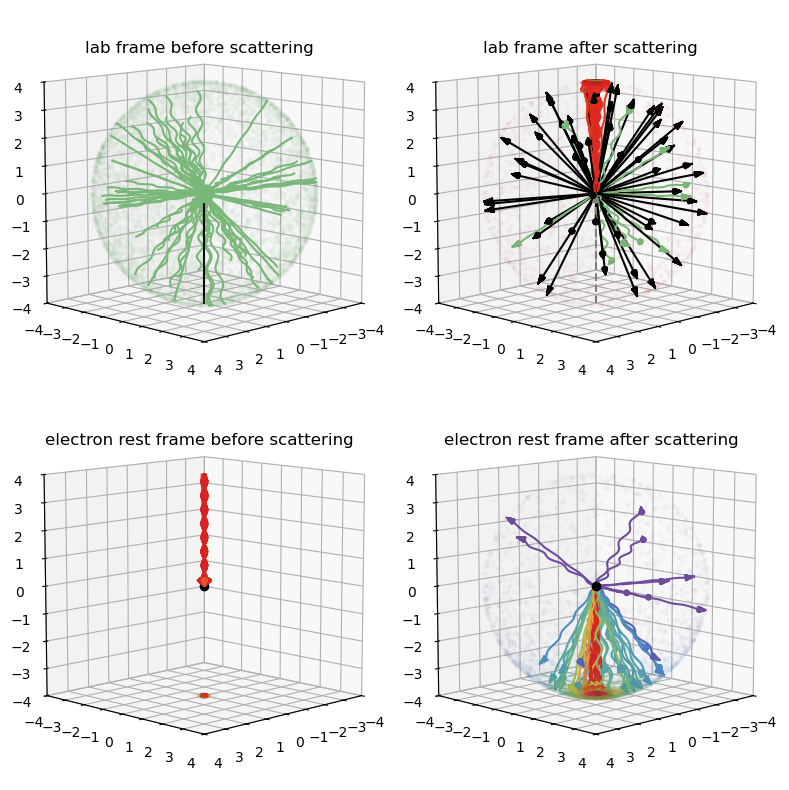

In [22]:
fig2